# Poisson Blending

This homework will use poisson blending to explore gradient-domain processing. Below is the effect:

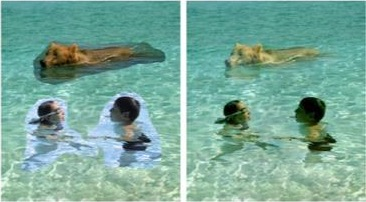


We can formulate it as a least squares problem, as follows:
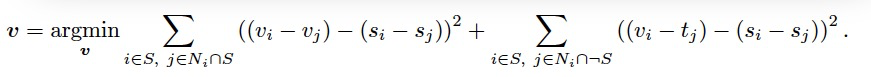



s: source cutout image

t: target image

v: new image whose gradients inside the region s are similar to the gradients of the cutout


### 1. Toy Problem

1. Minimize the difierence between the x-gradients of v and the x-gradients of s, that is,
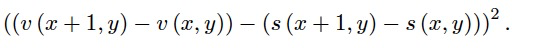
2. Minimize the difierence between the y-gradients of v and the y-gradients of s, that is,
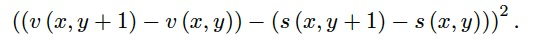
￼
3. Minimize the difierence between the colors of the top left corners of the two images,
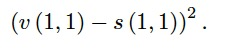
4. Combine all of the above objectives into a single least-squares problem, expressed in matrix form:
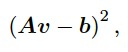

In [30]:
import cv2
import numpy as np
import scipy.signal as signal  
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
from scipy.linalg import solveh_banded
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import scipy.sparse as sp
import sys



In [31]:
'''
show figures
imageLists:   all the show image in lists
imageTitles:  all the image titles in lists, it's responce to imageLists
colNum:       the number of cols
supTitle:     add a centered title to the figure
isGray:       the image is draw in gray channel
'''
def show_figures(imageLists, imageTitles, col, supTitle='', isGray=False):
    plt.figure(figsize=(12,8))
    if supTitle.strip() != '':
        plt.suptitle(supTitle, fontsize=15)

    imageSize = len(imageLists)
    p1 = imageSize / col

    i = 1
    for image in imageLists:
        plt.subplot(p1,col,i)
        if(isGray):
            plt.imshow(image, cmap=plt.cm.gray)
        else:
            plt.imshow(image)
        
        plt.title(imageTitles[i-1])
        i = i + 1

    plt.show()
    
def normFloatArray(imgIn):
    """
    Normalize input float array value to between [0, 1]
    If the input image has multi-channels, it does the normalization
    channel by channel, independently.
    
    Parameters
    ----------
    imgIn: input image array

    Returns
    -------
    output image, value between [0, 1]
    """
    imgOut = (np.float32(imgIn)).copy()
    if imgIn.max()==imgIn.min():
        imgOut = np.zeros(imgIn.shape)
    elif len(imgIn.shape)==2:        
        imgOut = (imgOut - imgOut.min())/(imgOut.max()-imgOut.min())
    elif len(imgIn.shape)==3:
        for c in range(3):
            imgOut[:,:,c] = (imgOut[:,:,c] - imgOut[:,:,c].min())/(imgOut[:,:,c].max()-imgOut[:,:,c].min())
    return imgOut

### 1.1 Compute Gradiend and Divergence

In [32]:
def computeGradiend(img):
    
    kernelX = np.asarray([[0, -1, 1]])
    kernelY = kernelX.reshape(3,1)

    shapeLen = len(img.shape)
    if  shapeLen == 2:
        gradiendX = convolve(img, kernelX)
        gradiendY = convolve(img, kernelY)
        return gradiendX, gradiendY
    elif shapeLen == 3:
        channel = img.shape[2]
        gradiendX = np.zeros((img.shape), dtype=img.dtype)
        gradiendY = np.zeros((img.shape), dtype=img.dtype)
        for i in range(channel):
            gradiendX[:,:,i] = convolve(img[:,:,i], kernelX)
            gradiendY[:,:,i] = convolve(img[:,:,i], kernelY)
        return gradiendX, gradiendY


def computeDivergence(gradiendX, gradiendY):
    kernelX = np.asarray([[-1, 1, 0]])
    kernelY = kernelX.reshape(3,1)

    shapeLen = len(gradiendX.shape)
    if shapeLen == 2:
        divX = convolve(gradiendX, kernelX)
        divY = convolve(gradiendY, kernelY)
        return divX, divY
    elif shapeLen == 3:
        channel = gradiendX.shape[2]
        divX = np.zeros((gradiendX.shape), dtype=gradiendX.dtype)
        divY = np.zeros((gradiendY.shape), dtype=gradiendY.dtype)
        for i in range(channel):
            divX[:,:,i] = convolve(gradiendX[:,:,i], kernelX)
            divY[:,:,i] = convolve(gradiendY[:,:,i], kernelY)
        return divX, divY

def computeEdgeMask(img):
    imgH = img.shape[0]
    imgW = img.shape[1]
    maskImg = np.ones((img.shape), dtype = img.dtype)

    maskTmp = np.ones((img.shape[0:2]), dtype = img.dtype)
    for i in range(imgH):
        for j in range(imgW):
            if i == 0 or j == 0 or i == (imgH-1) or j == (imgW-1):
                maskTmp[i][j] = 0

    if len(img.shape) == 3:
        maskImg[:,:,0] = maskTmp
        maskImg[:,:,1] = maskTmp
        maskImg[:,:,2] = maskTmp
    else:
        maskImg = maskTmp.copy()
    
    return maskImg
            

### 1.1.1 Show gradient and laplacian image

('Input image has:', (119, 110), ' dtype:', dtype('float32'))
('Mask image has:', (119, 110), ' dtype:', dtype('float32'))
('toyGradiend image has:', (119, 110), ' dtype:', dtype('float32'))
('toyDiv image has:', (119, 110), ' dtype:', dtype('float32'))


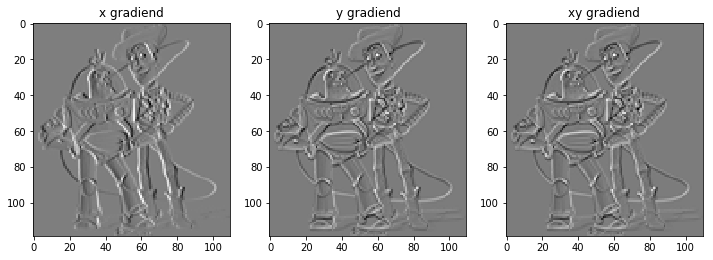

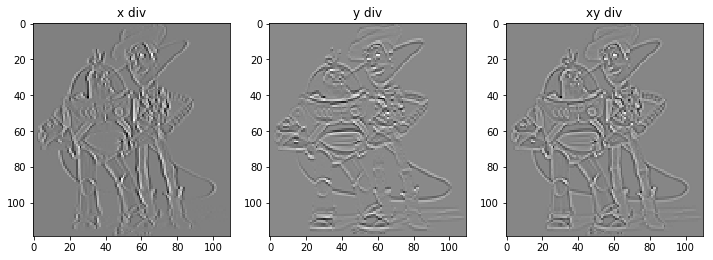

In [33]:
### load image
toyImg = cv2.imread('../data/toy_problem.png')
toyImg = cv2.cvtColor(toyImg, cv2.COLOR_BGR2GRAY)
toyImgFloat = normFloatArray(toyImg)
print("Input image has:", toyImgFloat.shape, " dtype:", toyImgFloat.dtype)

### compute mask
maskFloat = computeEdgeMask(toyImgFloat)
print("Mask image has:", maskFloat.shape, " dtype:", maskFloat.dtype)
# show_figures([toyImgFloat, maskFloat], ["toy image","maskFloat"], 2, isGray=True)


### show gradiend
gradiendX,gradiendY = computeGradiend(toyImgFloat)
toyGradiend = np.add(gradiendX,gradiendY)
### show laplacian
divX,divY = computeDivergence(gradiendX, gradiendY)
toyDiv = np.add(divX,divY)

print("toyGradiend image has:", toyGradiend.shape, " dtype:", toyGradiend.dtype)
print("toyDiv image has:", toyDiv.shape, " dtype:", toyDiv.dtype)

show_figures([gradiendX,toyGradiend, toyGradiend], ["x gradiend","y gradiend", "xy gradiend"], 3, isGray=True)
show_figures([divX,divY, toyDiv], ["x div","y div", "xy div"], 3, isGray=True)

### 1.2 reconstruct image
Use these gradients, plus one pixel intensity, to reconstruct image

('toyGradiend min:', -1.0, ' max:', 1.0627451)


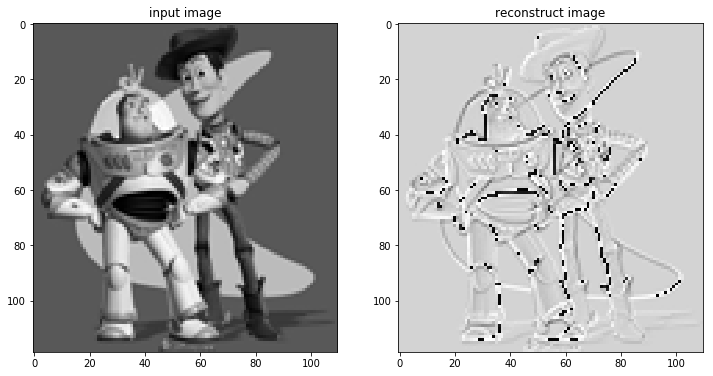

In [34]:
print("toyGradiend min:" , np.min(toyGradiend) , " max:" , np.max(toyGradiend))
toyGrad = normFloatArray(toyGradiend)
reconImg = toyGrad + toyImgFloat[1,1]
reconImg = np.uint8(reconImg * 255)
show_figures([toyImgFloat,reconImg], ["input image","reconstruct image"], 2, isGray=True)


### 1.3 Compute Sparse Matrix A

In [35]:
def hcomputeA(maskImg):
    mask = maskImg.copy()
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    imgH = mask.shape[0]
    imgW = mask.shape[1]
    matrixA = sp.identity(imgW * imgH, format='lil')
    matrixA = matrixA.toarray()
    
    colLength = imgH * imgW
    for i in range(imgH):
        for j in range(imgW):
            rowA = i * imgW + j
            if mask[i][j] == 1:
                matrixA[rowA][rowA] = -4
                for k in [-imgW, -1, 1, imgW]:
                    index = rowA + k
                    if index < colLength and index >= 0:
                        matrixA[rowA][index] = 1
            elif mask[i][j] == 0:
                matrixA[rowA][rowA] = 1

#     matrixA = matrixA.tocsr() 
    matrixA = csr_matrix(matrixA)
    print("matrixA has:", matrixA.shape, " dtype:", matrixA.dtype)
    return matrixA

def hcomputeB(bgImg, targeImg, maskImg):
    imgH = maskImg.shape[0]
    imgW = maskImg.shape[1]
    ### 1.compute divergence of original
    gradiendX,gradiendY = computeGradiend(targeImg)
    divX,divY = computeDivergence(gradiendX, gradiendY)
    divImg = np.add(divX,divY)
    print("divImg has:", divImg.shape, " dtype:", divImg.dtype)

    ### 2. get original pixel value in edge area
    bgEdgeImg = bgImg * (1-maskImg)
    divImg = divImg * maskImg

    b = divImg + bgEdgeImg
    if len(b.shape) == 3:
        b = b.reshape(imgH * imgW, b.shape[2])
    else:
        b = b.reshape(imgH * imgW)
    return b



### 1.3.1 Test 4*4 matrix

In [36]:
def testData(num):
    len = num * num
    data = np.asarray(np.arange(len))
    data = data.reshape(num,num)
    print("data: ",data)
    

    ### 0.comput mask
    maskImg = computeEdgeMask(data)
    print("maskImg: ",maskImg)
    

    ### 1.compute b
    b = hcomputeB(data, data, maskImg)
    print("b shape: ",b.shape, b.dtype)
    
    ## 2.compute A
    matrixA = hcomputeA(maskImg)
    print("A shape: ",matrixA.shape, matrixA.dtype)
    
    ### 3.solve sparse matrix
    x = spsolve(matrixA, b)
    xfloat = normFloatArray(x)
    out = xfloat.reshape(maskImg.shape)
#     out = normFloatArray(out)
    
    print("out: ",out)
    
    return out



testOut = testData(4)

('data: ', array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]]))
('maskImg: ', array([[0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 0]]))
('divImg has:', (4, 4), ' dtype:', dtype('int64'))
('b shape: ', (16,), dtype('int64'))
('matrixA has:', (16, 16), ' dtype:', dtype('float64'))
('A shape: ', (16, 16), dtype('float64'))
('out: ', array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]], dtype=float32))


### 1.4 reconstruct image by solve equation

('matrixA has:', (13090, 13090), ' dtype:', dtype('float64'))
('A shape: ', (13090, 13090), dtype('float64'))
('divImg has:', (119, 110), ' dtype:', dtype('float32'))
('b shape: ', (13090,), dtype('float32'))
('before out min:', 9.05902854648295e-08, ' max:', 1.0000002462969646)
('after out min:', 9.05902854648295e-08, ' max:', 1.0000002462969646)
('xshape:', 9.05902854648295e-08, 1.0000002462969646)


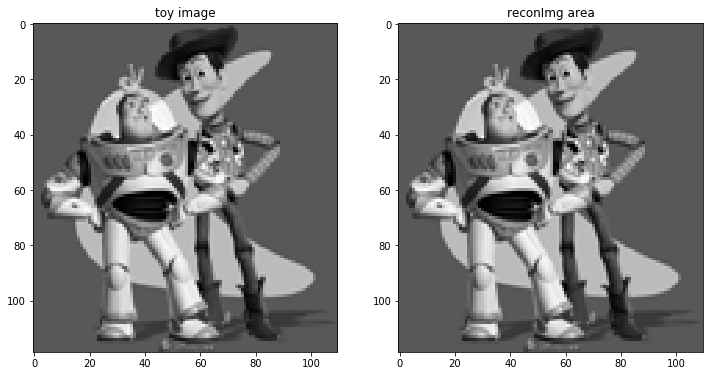

In [37]:
'''
bgImg: [0,1]
targeImg: [0,1]
maskImg: [0,1]
edgeImg: [0,1]
exEdgeImg: [0,1]
'''
def hreconstructInput(bgImg, targeImg, maskImg):
    if targeImg.shape[:2] != maskImg.shape[:2]:
        print("input image is not equal")
        return

    ### 1.compute A
    matrixA = hcomputeA(maskImg)
    print("A shape: ",matrixA.shape, matrixA.dtype)

    ### 2.compute B
    b = hcomputeB(bgImg, targeImg, maskImg)
    print("b shape: ",b.shape, b.dtype)

    ### 3.solve sparse matrix
    x = spsolve(matrixA, b)
#     xfloat = normFloatArray(x)
    out = x.reshape(maskImg.shape)
    print("before out min:", np.min(out) , " max:" , np.max(out))
    out[out<0] = 0
    print("after out min:", np.min(out) , " max:" , np.max(out))
    return out

reconImg = hreconstructInput(toyImgFloat, toyImgFloat, maskFloat)
print("xshape:", np.min(reconImg), np.max(reconImg))

cv2.imwrite("../data/reconnToy.jpg", np.uint8(reconImg * 255))
show_figures([toyImgFloat, reconImg], ["toy image","reconImg area"], 2, isGray=True)


### 2 Poisson blending

### 2.1 Load penguin and penguin mask image

('Input Hiking image has:', (2112, 2816, 3), ' dtype:', dtype('float32'))
--------load penguin chick------
('pSize:', 80, '-', 100)
('Input mask image has:', (100, 80, 3), ' dtype:', dtype('float32'))
('Input image has:', (100, 80, 3), ' dtype:', dtype('float32'))
(' y:', 0, ':', 100, 'x:', 0, ':', 80)
('--------pcMaskImgFloat has:', (100, 80, 3), ' dtype:', dtype('float32'))
('After cut:Input image has:', (100, 80, 3), ' dtype:', dtype('float32'))
('After cut:Input mask image has:', (100, 80, 3), ' dtype:', dtype('float32'))
('After cut:Input hiking area image has:', (100, 80, 3), ' dtype:', dtype('float32'))


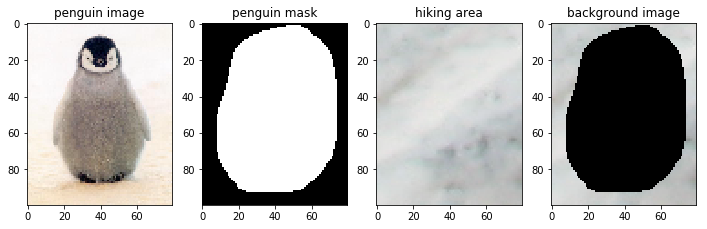

In [95]:
def findMinRect(maskImg):
    img = maskImg.copy()
    if len(img.shape) == 3:
        img = img[:,:,0]
    minx = sys.maxint
    maxx = -1
    miny = sys.maxint
    maxy = -1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == 1:
                if miny > i:
                    miny = i
                if maxy < i:
                    maxy = i
                if minx > j:
                    minx = j
                if maxx < j:
                    maxx = j
#     print("x:", minx, ":", maxx, " y:" , miny , ":" , maxy)
#     return miny-1, maxy+1, minx-1, maxx+1
    print(" y:" , 0 , ":" , img.shape[0], "x:", 0, ":", img.shape[1] )
    return 0, img.shape[0], 0, img.shape[1]

def loadImg(imgPath, imgMaskPath, ratio, isGray):
    ### click mask image
    pcMaskImg = cv2.imread(imgMaskPath)
    if isGray == True:
        pcMaskImg = cv2.cvtColor(pcMaskImg, cv2.COLOR_BGR2GRAY)
    pSize = (np.int16(pcMaskImg.shape[1] * ratio), np.int16(pcMaskImg.shape[0] * ratio))
    print("pSize:", pSize[0], "-",pSize[1])
    pcMaskImg = cv2.resize(pcMaskImg, pSize)
    pcMaskImg[pcMaskImg<255]=0
    pcMaskImgFloat = normFloatArray(pcMaskImg)
    print("Input mask image has:", pcMaskImgFloat.shape, " dtype:", pcMaskImgFloat.dtype)

    ### penguin click image
    pcImg = cv2.imread(imgPath)
    if isGray == True:
        pcImg = cv2.cvtColor(pcImg, cv2.COLOR_BGR2GRAY)
    pcImgFloat = normFloatArray(pcImg)
    pcImgFloat = cv2.resize(pcImgFloat, pSize)
    print("Input image has:", pcImgFloat.shape, " dtype:", pcImgFloat.dtype)

    ### find the minmum enclosing rect
    miny, maxy, minx, maxx = findMinRect(pcMaskImgFloat)
    
    print("--------pcMaskImgFloat has:", pcMaskImgFloat.shape, " dtype:", pcMaskImgFloat.dtype)
    
    pcMaskImgFloat = pcMaskImgFloat[miny:maxy, minx:maxx]
    pcImgFloat = pcImgFloat[miny:maxy, minx:maxx]
    print("After cut:Input image has:", pcImgFloat.shape, " dtype:", pcImgFloat.dtype)
    print("After cut:Input mask image has:", pcMaskImgFloat.shape, " dtype:", pcMaskImgFloat.dtype)
    return pcImgFloat, pcMaskImgFloat

ratio = 0.2
isLoadGray = False
### backgound image
hikingImg = cv2.imread('../data/hiking.jpg')
if isLoadGray == True:
    hikingImg = cv2.cvtColor(hikingImg, cv2.COLOR_BGR2GRAY)
hikingImgFloat = normFloatArray(hikingImg)
print("Input Hiking image has:", hikingImgFloat.shape, " dtype:", hikingImgFloat.dtype)

print("--------load penguin chick------")
pcImgPath = '../data/penguin-chick.jpg'
pcMaskPath = '../data/penguin-chick_mask.png'
pcImgFloat, pcMaskImgFloat = loadImg(pcImgPath, pcMaskPath, ratio, isLoadGray)

### crop hiking area
blendLeft = 1000
blendTop = 1800
rowEnd = (blendTop+pcImgFloat.shape[0])
colEnd = (blendLeft+pcImgFloat.shape[1])
hikeAreaFloat = hikingImgFloat[blendTop:rowEnd, blendLeft:colEnd]
print("After cut:Input hiking area image has:", hikeAreaFloat.shape, " dtype:", hikeAreaFloat.dtype)

show_figures([pcImgFloat, pcMaskImgFloat, hikeAreaFloat, hikeAreaFloat * (1-pcMaskImgFloat)], 
             ["penguin image","penguin mask", "hiking area", "background image"], 4, isGray=isLoadGray)


--------load penguin------
('pSize:', 66, '-', 100)
('Input mask image has:', (100, 66, 3), ' dtype:', dtype('float32'))
('Input image has:', (100, 66, 3), ' dtype:', dtype('float32'))
(' y:', 0, ':', 100, 'x:', 0, ':', 66)
('--------pcMaskImgFloat has:', (100, 66, 3), ' dtype:', dtype('float32'))
('After cut:Input image has:', (100, 66, 3), ' dtype:', dtype('float32'))
('After cut:Input mask image has:', (100, 66, 3), ' dtype:', dtype('float32'))
('After cut:Input hiking area2 image has:', (100, 66, 3), ' dtype:', dtype('float32'))


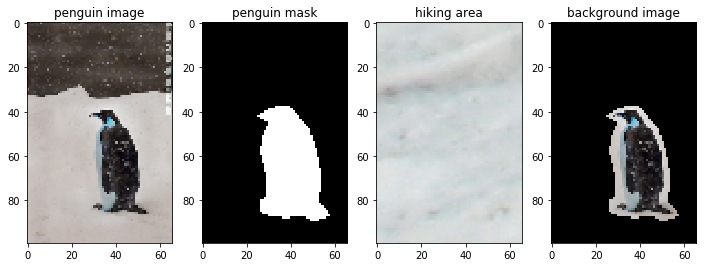

In [96]:
print("--------load penguin------")
pImgPath = '../data/penguin.jpg'
pMaskPath = '../data/penguin_mask.png'

pImgFloat, pMaskImgFloat = loadImg(pImgPath, pMaskPath, ratio, isLoadGray)

### crop hiking area2
blendLeft2 = 1100
blendTop2 = 1500
rowEnd2 = (blendTop2+pImgFloat.shape[0])
colEnd2 = (blendLeft2+pImgFloat.shape[1])
hikeAreaFloat2 = hikingImgFloat[blendTop2:rowEnd2, blendLeft2:colEnd2]
print("After cut:Input hiking area2 image has:", hikeAreaFloat2.shape, " dtype:", hikeAreaFloat2.dtype)
show_figures([pImgFloat, pMaskImgFloat, hikeAreaFloat2, pImgFloat * (pMaskImgFloat)], 
             ["penguin image","penguin mask", "hiking area", "background image"], 4, isGray=isLoadGray)


### 2.2  Possion blending with Rect Area

('matrixA has:', (8000, 8000), ' dtype:', dtype('float64'))
('A shape: ', (8000, 8000), dtype('float64'))
('divImg has:', (100, 80, 3), ' dtype:', dtype('float32'))
('b shape: ', (8000, 3), dtype('float32'))
('before out min:', -0.19774763021921754, ' max:', 0.9328063130378723)
('after out min:', 0.0, ' max:', 0.9328063130378723)
('reconImg min:', 0.0, ' max:', 0.9328063130378723)


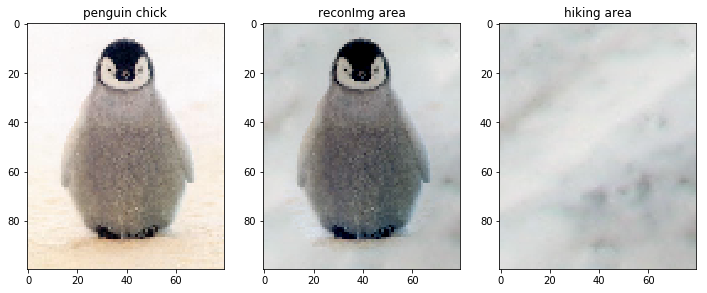

In [56]:
### blend with penguin chick
reconImg = hreconstructInput(hikeAreaFloat, pcImgFloat, pcMaskImgFloat)
print("reconImg min:", np.min(reconImg), " max:", np.max(reconImg))

hikingImg[blendTop:rowEnd, blendLeft:colEnd]=np.uint8(reconImg*255)
cv2.imwrite("../data/out1.jpg", hikingImg)

show_figures([pcImgFloat, reconImg, hikeAreaFloat], ["penguin chick","reconImg area", "hiking area"], 3, isGray=True)


('matrixA has:', (6600, 6600), ' dtype:', dtype('float64'))
('A shape: ', (6600, 6600), dtype('float64'))
('divImg has:', (100, 66, 3), ' dtype:', dtype('float32'))
('b shape: ', (6600, 3), dtype('float32'))
('before out min:', -0.028902254566735706, ' max:', 0.9410913431359414)
('after out min:', 0.0, ' max:', 0.9410913431359414)
('reconImg2 min:', 0.0, ' max:', 0.9410913431359414)


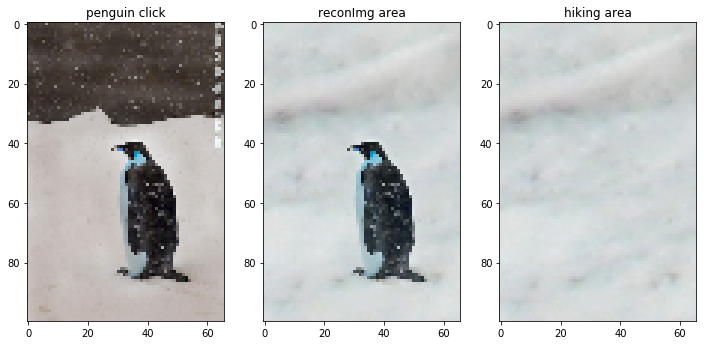

In [57]:
### blend with penguin
reconImg2 = hreconstructInput(hikeAreaFloat2, pImgFloat, pMaskImgFloat)
print("reconImg2 min:", np.min(reconImg2), " max:", np.max(reconImg2))

hikingImg[blendTop2:rowEnd2, blendLeft2:colEnd2]=np.uint8(reconImg2 *255)
cv2.imwrite("../data/out2.jpg", hikingImg)
show_figures([pImgFloat, reconImg2, hikeAreaFloat2], ["penguin click","reconImg area", "hiking area"], 3, isGray=True)


### 3.Blending with mixed gradients

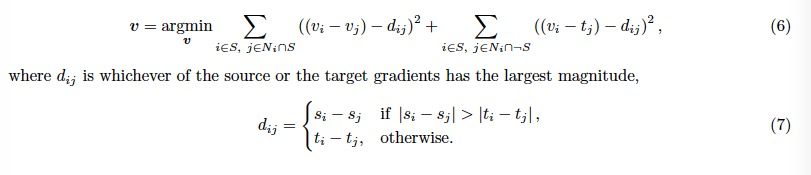

('matrixA has:', (6600, 6600), ' dtype:', dtype('float64'))
('A shape: ', (6600, 6600), dtype('float64'))
('divImg has:', (100, 66, 3), ' dtype:', dtype('float32'))
('b shape: ', (6600, 3), dtype('float32'))
('before out min:', -0.004328839040859966, ' max:', 0.9604018188067256)
('after out min:', 0.0, ' max:', 0.9604018188067256)


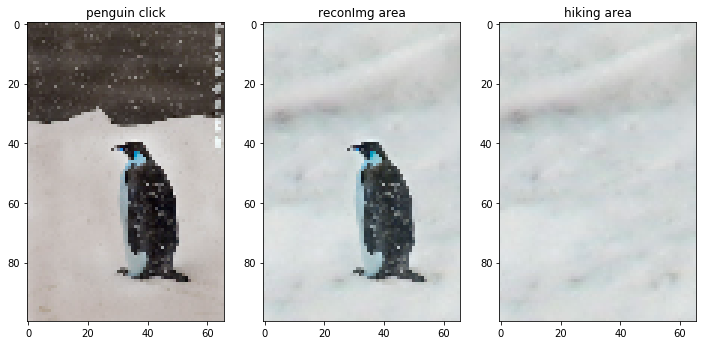

In [71]:
def computeB(bgImg, targeImg, maskImg, largeGradX, largeGradY):
    imgH = maskImg.shape[0]
    imgW = maskImg.shape[1]
    ### 1.compute divergence of original
    gradiendX,gradiendY = computeGradiend(targeImg)
    
    gradiendX[gradiendX < largeGradX] = largeGradX
    gradiendY[gradiendY < largeGradY] = largeGradY
    
    divX,divY = computeDivergence(gradiendX, gradiendY)
    divImg = np.add(divX,divY)
    print("divImg has:", divImg.shape, " dtype:", divImg.dtype)

    ### 2. get original pixel value in edge area
    bgEdgeImg = bgImg * (1-maskImg)
    divImg = divImg * maskImg

    b = divImg + bgEdgeImg
    if len(b.shape) == 3:
        b = b.reshape(imgH * imgW, b.shape[2])
    else:
        b = b.reshape(imgH * imgW)
    return b


def reconInput(bgImg, targeImg, maskImg, largeGardX, largeGardY):
    if targeImg.shape[:2] != maskImg.shape[:2]:
        print("input image is not equal")
        return

    ### 1.compute A
    matrixA = hcomputeA(maskImg)
    print("A shape: ",matrixA.shape, matrixA.dtype)

    ### 2.compute B
    b = computeB(bgImg, targeImg, maskImg, largeGardX, largeGardY)
    print("b shape: ",b.shape, b.dtype)

    ### 3.solve sparse matrix
    x = spsolve(matrixA, b)
    out = x.reshape(maskImg.shape)
    print("before out min:", np.min(out) , " max:" , np.max(out))
    out[out<0] = 0
    print("after out min:", np.min(out) , " max:" , np.max(out))
    return out

largeGardX = -0.5
largeGardY = -0.5
recImg = reconInput(hikeAreaFloat2, pImgFloat, pMaskImgFloat, largeGardX, largeGardY)

hikingImg[blendTop2:rowEnd2, blendLeft2:colEnd2]=np.uint8(recImg *255)
cv2.imwrite("../data/out_large_gradiend.jpg", hikingImg)
show_figures([pImgFloat, recImg, hikeAreaFloat2], ["penguin click","reconImg area", "hiking area"], 3, isGray=True)


### 4.Your own examples

Show at least three results for each. Explain any failure cases (e.g., weird colors, blurred boundaries, etc.). We discussed some failure cases in class, so you can try to reproduce those. For mixed gradients, one possible example is blending a picture of writing on a plain background onto another image.

('Input test image has:', (1080, 1440, 3), ' dtype:', dtype('float32'))
--------load panda image------
('pSize:', 153, '-', 102)
('Input mask image has:', (102, 153, 3), ' dtype:', dtype('float32'))
('Input image has:', (102, 153, 3), ' dtype:', dtype('float32'))
(' y:', 0, ':', 102, 'x:', 0, ':', 153)
('--------pcMaskImgFloat has:', (102, 153, 3), ' dtype:', dtype('float32'))
('After cut:Input image has:', (102, 153, 3), ' dtype:', dtype('float32'))
('After cut:Input mask image has:', (102, 153, 3), ' dtype:', dtype('float32'))
('After cut:Input test area image has:', (102, 153, 3), ' dtype:', dtype('float32'))


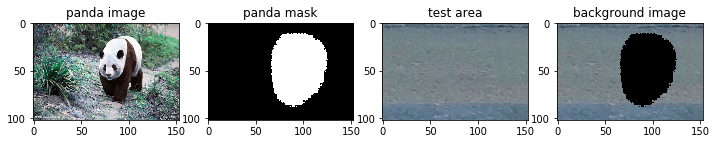

In [92]:
ratio = 0.3
isLoadGray = False
### backgound image
testImg = cv2.imread('../data/test.jpg')
if isLoadGray == True:
    testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2GRAY)
testImgFloat = normFloatArray(testImg)
print("Input test image has:", testImgFloat.shape, " dtype:", testImgFloat.dtype)

print("--------load panda image------")
pandaImgPath = '../data/test_panda.jpg'
pandaMaskPath = '../data/test_panda_mask.jpg'
pandaImgFloat, pandaMaskFloat = loadImg(pandaImgPath, pandaMaskPath, ratio, isLoadGray)

### crop hiking area
blendL = 1100
blendT = 630
rowEnd = (blendT+pandaImgFloat.shape[0])
colEnd = (blendL+pandaImgFloat.shape[1])
testAreaFloat = testImgFloat[blendT:rowEnd, blendL:colEnd]
print("After cut:Input test area image has:", testAreaFloat.shape, " dtype:", testAreaFloat.dtype)

show_figures([pandaImgFloat, pandaMaskFloat, testAreaFloat, testAreaFloat * (1-pandaMaskFloat)], 
             ["panda image","panda mask", "test area", "background image"], 4, isGray=isLoadGray)


('matrixA has:', (15606, 15606), ' dtype:', dtype('float64'))
('A shape: ', (15606, 15606), dtype('float64'))
('divImg has:', (102, 153, 3), ' dtype:', dtype('float32'))
('b shape: ', (15606, 3), dtype('float32'))
('before out min:', -0.23394854439147555, ' max:', 0.979588978317427)
('after out min:', 0.0, ' max:', 0.979588978317427)


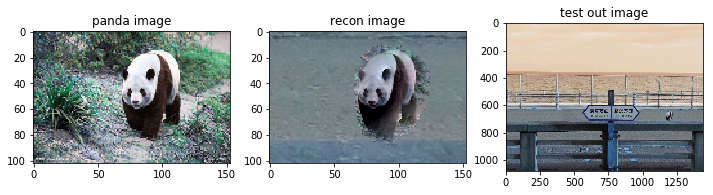

In [94]:
largeGardX = -0.1
largeGardY = -0.1
recImg = reconInput(testAreaFloat, pandaImgFloat, pandaMaskFloat, largeGardX, largeGardY)

testImg[blendT:rowEnd, blendL:colEnd]=np.uint8(recImg *255)
cv2.imwrite("../data/out_panda.jpg", testImg)
show_figures([pandaImgFloat, recImg, testImg], ["panda image","recon image", "test out image"], 3, isGray=True)


From the reconstuct image, we see the result is fake and artificial. Because of the source image is complicated source image and background image of the color is so difference.

### 5  (Deprecated)Standard possion blending with heteromorphism
### 5.1 Compute Edge Mask

In [42]:
from scipy.ndimage.filters import convolve

### convolve only can handle gray image
# edge_filter = np.asarray(
#     [[0, 1, 0],
#      [1, 5, 1],
#      [0, 1, 0]])

# pcEdgeImg = convolve(pcMaskImgFloat, edge_filter)
# pcExEdgeImg = pcEdgeImg.copy()
# pcExEdgeImg[pcExEdgeImg >= 5 ] = 0
# pcExEdgeImg[pcExEdgeImg > 0] = 1


# pcEdgeImg[pcEdgeImg == 9 ] = 0
# pcEdgeImg[pcEdgeImg < 6] = 0
# pcEdgeImg[pcEdgeImg >= 6 ] = 1

# cv2.imwrite("../data/testMask.png", pcMaskImg, [int(cv2.IMWRITE_PNG_COMPRESSION), 100])
# cv2.imwrite("../data/testEdge.png", pcEdgeImg, [int(cv2.IMWRITE_PNG_COMPRESSION), 100])
# cv2.imwrite("../data/testOut.png", (pcMaskImgFloat * pcImgFloat) * 255, [int(cv2.IMWRITE_PNG_COMPRESSION), 100])

# show_figures([pcMaskImgFloat, pcEdgeImg], ["penguin click mask","click mask edge image"], 2, isGray=True)

### 5.2 Reconstruct image

In [43]:
def isNeighbor(pixels, p, q):
    i1 = pixels[p] / 10000 #hight
    j1 = pixels[p] % 10000 #width
    
    i2 = pixels[q] / 10000 #hight
    j2 = pixels[q] % 10000 #width
    
    if i1 == i2 or j1 == j2:
        return True
    else:
        return False

'''
maskImg: [0,1]
edgeImg: [0,1]
'''
def computeA2(maskImg):
    imgH = maskImg.shape[0]
    imgW = maskImg.shape[1]
    
    ## 1.count pixel in mask
    pixels = []
    for i in range(imgH):
        for j in range(imgW):
            if maskImg[i][j] == 1:
                coorV = 10000 * i + j
                pixels.append(coorV)
            
    pixels=np.array(pixels)
    nums = pixels.shape[0]
    print("pixels:", nums)
    
    ## 2.computete matrix a
    matrixA = np.zeros((nums, nums), dtype = 'float32')
    
    for i in range(nums):
        for j in range(nums):
            if i == j:
                matrixA[i][j] = -4
            elif isNeighbor(pixels, i, j) == True:
                matrixA[i][j] = 1
            else:
                matrixA[i][j] = 0
    print("matrixA:", matrixA.shape)
    return matrixA

def computeB(bgImg, targeImg, maskImg, edgeImg, exEdgeImg):
    imgH = maskImg.shape[0]
    imgW = maskImg.shape[1]
    ### 1.compute divergence of original
    gradiendX,gradiendY = computeGradiend(targeImg)
    grayGradiend = np.add(gradiendX,gradiendY)
    divX,divY = computeDivergence(gradiendX, gradiendY)
    divImg = np.add(divX,divY)
    print("divImg has:", divImg.shape, " typy:", divImg.dtype)

    ### 2. get original pixel value in edge area
    bgEdgeImg = bgImg * edgeImg

    ### 3.conunt div in mask
    div = []
    k = 0
    for i in range (imgH):
        for j in range (imgW):
            if maskImg[i][j] == 1:
                div.append(divImg[i][j])
    div = np.array(div)
    print("div in mask shape:", div.shape, " dtype:", div.dtype)
    
    ### 4. count neighbor in edge area
    k = 0
    nerghbor = np.zeros((div.shape))
    for i in range (imgH):
        for j in range (imgW):
            if maskImg[i][j] == 1:
                if edgeImg[i][j] == 1:
                    for p in [-1, 1]:
                        if exEdgeImg[i+p][j] == 1:
                            nerghbor[k] = bgEdgeImg[i+p][j]
                        if exEdgeImg[i][j+p] == 1:
                            nerghbor[k] = bgEdgeImg[i][j+p]
                            
                k = k + 1
    print("nerghbor in mask shape:", nerghbor.shape, " dtype:", nerghbor.dtype)
    
    b = div + nerghbor
    return b
'''
bgImg: [0,1]
targeImg: [0,1]
maskImg: [0,1]
edgeImg: [0,1]
exEdgeImg: [0,1]
'''
def reconstructInput(bgImg, targeImg, maskImg, edgeImg, exEdgeImg):
    if targeImg.shape[:2] != maskImg.shape[:2] or maskImg.shape[:2] != edgeImg.shape[:2]:
        print("input image is not equal")
        return

    ### 1.compute B
    b = computeB(bgImg, targeImg, maskImg, edgeImg, exEdgeImg)

    ### 2.compute A
    matrixA = computeA2(maskImg)
    matrixASparse = csr_matrix(matrixA)
    print("A shape: ",matrixA.shape, matrixA.dtype)

    ### 3.solve sparse matrix
    x = spsolve(matrixASparse, b)
    xfloat = normFloatArray(x)
    
    ### 4.copy back
    ### TODO
    return xfloat

# reconImg = reconstructInput(hikeAreaFloat, pcImgFloat, pcMaskImgFloat, pcEdgeImg, pcExEdgeImg)
# print("xshape:", np.min(reconImg), np.max(reconImg))

# show_figures([pcImgFloat, reconImg], ["penguin click mask","reconImg"], 2, isGray=True)
